In [1]:
using_numpy = False
try:
    import cupy as np
except:
    import numpy as np
    using_numpy = True
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


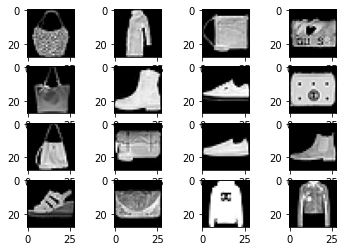

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        if not using_numpy:
            img = img.get()
        axarr[i, j].imshow(img)

## 3.3 Implementing the algorithm

In [5]:
def sigmoid(z):
#     return 1. / (1. + np.exp(-z))
    return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [45]:
# forward pass
def forward(params, x):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["w2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    
    return forward_res

# backpropagation
def backprop(x, y, params):
    x = x.reshape(28**2, 1)
    grads = {}
    
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["w2"].dot(a1) + params["b2"]
    y_pred = a2 = sigmoid(z2)
    
    dL_dz2 = (a2 - y)
    dL_dz1 = dL_dz2 * params["w2"].T * sigmoid_d(z1)
                                                 
    grads["dw2"] = dL_dz2 * a1.T
    grads["db2"] = dL_dz2
    
    grads["dW1"] = dL_dz1 @ x.T
    grads["db1"] = dL_dz1

    return grads

In [46]:
def predict_raw(x, params):
    forward_res = forward(params, x)
    return forward_res["a2"][0, 0]

def predict_mlp(x, params):    
    forward_res = forward(params, x)
    if forward_res["a2"] >= 0.5:
        return 1
    return 0

In [47]:
# function to calculate accuracy
def accuracy(xs, ys, params):
    nData = xs.shape[0]
    accuracy = 0
    for i in range(nData):
        yp = predict_mlp(xs[i], params)
        if (yp == ys[i]):
            accuracy += 1
    return (accuracy / nData) * 100

# CORRECT function to determine loss
def validation_loss(xs, ys, params):
    l = 0
    for i in range (xs.shape[0]):
        yprime = predict_raw(xs[i], params)
        if (yprime == 0 and ys[i] == 1):
            yprime += 1e-15
        elif yprime == 1 and ys[i] == 0:
            yprime -= 1e-15
        if ys[i] == 1:
            l += np.log(yprime)
        else:
            l += np.log(1 - yprime)
    return ((-1) / ys.shape[0]) * l

In [48]:
def update_params(grads, params, lr, momentum, dW1, db1, dw2, db2):
    # use momentum 1 so dW1 = grads["dW1"], db1 = grads["db1"]...
    dW1 = momentum * dW1 + (1 - momentum) * grads["dW1"]
    db1 = momentum * db1 + (1 - momentum) * grads["db1"]
    dw2 = momentum * dw2 + (1 - momentum) * grads["dw2"]
    db2 = momentum * db2 + (1 - momentum) * grads["db2"]

    params["W1"] -= (lr * dW1)
    params["b1"] -= lr * db1
    params["w2"] -= (lr * dw2)
    params["b2"] -= lr * db2
    return params

In [49]:
def update_grads(grads, ups, batch_size):
    grads["dw2"] += ups["dw2"] / batch_size
    grads["db2"] += ups["db2"] / batch_size
    
    grads["dW1"] += ups["dW1"] / batch_size
    grads["db1"] += ups["db1"] / batch_size
    return grads

In [50]:
def get_batch_indices(batch_size, nData):
    r = np.arange(nData)
    return np.split(r, (nData // batch_size))

In [60]:
def mlp(xs, ys, devxs, devys, n_epochs=3, learning_rate=0.1, momentum=0, batch_size=-1, h=19):
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]
    
    if batch_size == -1:
        batch_size = nData
    print("nData:", nData, "Hidden Layer size:", h, "Learning Rate:", learning_rate, "Momentum:", momentum, "Batch Size:", batch_size)
    
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []
    epochs = []
    
    # initialise parameters
    params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
    
    grads = {}
    
    for epoch in range(n_epochs):
        # shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        batch_indices = get_batch_indices(batch_size, nData)
        
        for batch in batch_indices:
            grads["dw2"] = np.zeros_like(params["w2"])
            grads["db2"] = np.zeros_like(params["b2"])

            grads["dW1"] = np.zeros_like(params["W1"])
            grads["db1"] = np.zeros_like(params["b1"])

            if epoch == 0:
                dW1 = np.zeros_like(params["W1"])
                db1 = np.zeros_like(params["b1"])

                dw2 = np.zeros_like(params["w2"])
                db2 = np.zeros_like(params["b2"])

            sgd = False
            if sgd:
                for i in batch:
                    forward_res = forward(params, trainxs_shuffled[i])
                    grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
                    params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
            else:
#                 for i in batch:
#                     forward_res = forward(params, trainxs_shuffled[i])
#                     ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
#                     grads = update_grads(grads, ups, trainxs_shuffled.shape[0])

#                 params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
                for i in batch:
                    ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                    grads["dw2"] += ups["dw2"] / batch_size
                    grads["db2"] += ups["db2"] / batch_size

                    grads["dW1"] += ups["dW1"] / batch_size
                    grads["db1"] += ups["db1"] / batch_size
                params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
                
                
        epochs.append(epoch)
        print("Epoch:", epoch)
        
        t_loss = validation_loss(xs, ys, params)
        t_losses.append(t_loss)
        t_acc = accuracy(xs, ys, params)
        t_accs.append(t_acc)
        print("Train Acc:", t_acc, "Train Loss:", t_loss)
        
        v_acc = accuracy(devxs, devys, params)
        v_accs.append(v_acc)
        v_loss = validation_loss(devxs, devys, params)
        v_losses.append(v_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)
        print("----------------------------------\n\n")
        
    return epochs, t_losses, t_accs, v_losses, v_accs

In [61]:
momentum = 0
epochs, t_losses, t_accs, v_losses, v_accs = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0,
    batch_size=1,
    h=19,
)

nData: 12000 Hidden Layer size: 19 Learning Rate: 0.01 Momentum: 0 Batch Size: 1
Epoch: 0
Train Acc: 96.40833333333333 Train Loss: 0.11293444187124507
Val Acc: 96.89999999999999 Val Loss: 0.09634752771070201
----------------------------------


Epoch: 1
Train Acc: 96.35000000000001 Train Loss: 0.10982611765980327
Val Acc: 97.2 Val Loss: 0.09213429310336331
----------------------------------


Epoch: 2
Train Acc: 97.26666666666667 Train Loss: 0.0843917886240612
Val Acc: 98.1 Val Loss: 0.07138362359474437
----------------------------------


Epoch: 3
Train Acc: 97.1 Train Loss: 0.08772298193273179
Val Acc: 97.39999999999999 Val Loss: 0.07550390859209746
----------------------------------


Epoch: 4
Train Acc: 97.56666666666666 Train Loss: 0.07449246349687402
Val Acc: 98.2 Val Loss: 0.0649593015222898
----------------------------------


Epoch: 5
Train Acc: 98.075 Train Loss: 0.06453957161071688
Val Acc: 98.4 Val Loss: 0.05896879695110446
----------------------------------


Epoch: 6
Trai

In [ ]:
update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)

In [42]:
momentum = 0
epochs, t_losses, t_accs, v_losses, v_accs = mlp(
    trainxs, trainys, 
    devxs, devys, 
    learning_rate=0.4,
    momentum=0,
    batch_size=-1,
    h=19,
)

nData: 12000 Hidden Layer size: 19 Learning Rate: 0.4 Momentum: 0 Batch Size: 12000
Epoch: 0
Train Acc: 46.800000000000004 Train Loss: 0.703357876648778
Val Acc: 45.6 Val Loss: 0.7053220881144602
----------------------------------


Epoch: 1
Train Acc: 63.916666666666664 Train Loss: 0.6809195878165692
Val Acc: 62.0 Val Loss: 0.6822092229837635
----------------------------------


Epoch: 2
Train Acc: 70.89999999999999 Train Loss: 0.6587480886879339
Val Acc: 69.89999999999999 Val Loss: 0.6595969116505993
----------------------------------




In [ ]:
# from sklearn.metrics import log_loss
# def mlp(xs, ys, learning_rate, momentum, devxs, devys):
#     img_size = 28**2
#     h = 19
#     out_size = 1
    
#     #     stores training set loss for part 3.5
#     loss_training = []
    
#     #     stores training set accuracy for part 3.6
#     accuracy_training = []
    
#     #     stores validation set accuracy for part 3.7
#     accuracy_validation = []
    
#     # initialise parameters
#     params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
#               "b1": np.zeros((h, 1)),
#               "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
#               "b2": np.zeros((out_size, 1))}
    
#     grads = {}
    
#     loss_old = validation_loss_c(devxs, devys, params)
#     print('loss_old', loss_old)
    
#     epoch = 0
#     row_epoch = 0
        
#     while True:
#         # shuffle training set
#         permutation = np.random.permutation(xs.shape[0])
#         trainxs_shuffled = xs[permutation]
#         trainys_shuffled = ys[permutation]
        
        
#         batches = [[i for i in range(xs_shuffled.shape[0])]]
        
        
        
#         grads["dw2"] = np.zeros_like(params["w2"])
#         grads["db2"] = np.zeros_like(params["b2"])

#         grads["dW1"] = np.zeros_like(params["W1"])
#         grads["db1"] = np.zeros_like(params["b1"])
        
#         if epoch == 0:
#             dW1 = np.zeros_like(params["W1"])
#             db1 = np.zeros_like(params["b1"])
            
#             dw2 = np.zeros_like(params["w2"])
#             db2 = np.zeros_like(params["b2"])
        
#         print("epoch", epoch)
#         sgd = True
#         if sgd:
#             for i in range (trainxs.shape[0]):
#                 forward_res = forward(params, trainxs_shuffled[i])
#                 grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
#                 params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
#         else:
#             for i in range (trainxs.shape[0]):
#                 forward_res = forward(params, trainxs_shuffled[i])
#                 ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
#                 grads = update_grads(grads, ups, trainxs_shuffled.shape[0])

#             params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
        
#         loss_t = validation_loss_c(xs, ys, params)
#         loss_training.append(loss_t)
        
#         accuracy_t = accuracy(xs, ys, params)
#         accuracy_training.append(accuracy_t)
    
#         accuracy_valid = accuracy(devxs, devys, params)
#         accuracy_validation.append(accuracy_valid)
        
#         loss_valid = validation_loss_c(devxs, devys, params)
#         print('validation loss', loss_valid)
#         print('want', log_loss(devys.get(), [predict_raw(x, params).get() for x in devxs]))
#         print('training loss', loss_t)
#         print('training accuracy', accuracy_t)
#         if np.abs(loss_valid - loss_old) == 0:
#             row_epoch += 1
#             if row_epoch == 5:
#                 break
#         else:
#             row_epoch = 0
#         loss_old = loss_valid
#         epoch += 1
# #         print(params)
#     return epoch, loss_training, accuracy_training, accuracy_validation